In [2]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
im os


In [3]:
seg_images_dir = '/kaggle/input/deepfashion-1/datasets/segm/'
seg_images_filenames_list = os.listdir(seg_images_dir)
seg_images_paths = [seg_images_dir + file for file in seg_images_filenames_list]
print(seg_images_paths[:5])
print(len(seg_images_paths))

['/kaggle/input/deepfashion-1/datasets/segm/WOMEN-Dresses-id_00007947-05_4_full_segm.png', '/kaggle/input/deepfashion-1/datasets/segm/WOMEN-Jackets_Coats-id_00004891-02_2_side_segm.png', '/kaggle/input/deepfashion-1/datasets/segm/WOMEN-Dresses-id_00005748-01_1_front_segm.png', '/kaggle/input/deepfashion-1/datasets/segm/WOMEN-Tees_Tanks-id_00006687-05_4_full_segm.png', '/kaggle/input/deepfashion-1/datasets/segm/WOMEN-Pants-id_00000478-02_1_front_segm.png']
11484


In [4]:
train_image_path = "/kaggle/input/deepfashion-1/datasets/train_images/"
segmentation_path = "/kaggle/input/deepfashion-1/datasets/segm/"

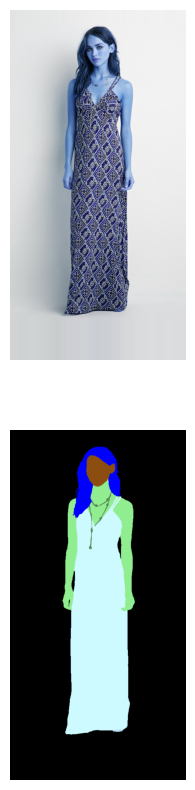

In [5]:
def load_image(image_id):
    img = cv2.imread(os.path.join(train_image_path, image_id))
    return img

def load_mask(image_id):
    mask = cv2.imread(os.path.join(segmentation_path, image_id))
    return mask
def get_mask_filename(image_id):
    return image_id.replace('.png', '_segm.png')

image_id = "WOMEN-Dresses-id_00006392-02_1_front.png"
image = load_image(image_id)
mask = load_mask(get_mask_filename(image_id))

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(mask)
plt.axis('off')

plt.show()

In [6]:
print(image.shape)

(1024, 512, 3)


In [7]:
print(mask.dtype)

uint8


In [8]:
import os
dir_path = '/kaggle/input/deepfashion-1/datasets/segm/'
file_count = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
print(file_count)

11484


In [9]:
import os
dir_path = '/kaggle/input/deepfashion-1/datasets/train_images/'
file_count = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
print(file_count)

10335


In [10]:
from sklearn.model_selection import train_test_split

image_dir = '/kaggle/input/deepfashion-1/datasets/train_images'
mask_dir = '/kaggle/input/deepfashion-1/datasets/segm'

image_filenames = os.listdir(image_dir)
mask_filenames = os.listdir(mask_dir)

image_paths = []
mask_paths = []
for image in image_filenames:
    mask_name = image.replace('.png', '_segm.png')
    if mask_name in mask_filenames:
        image_paths.append(os.path.join(image_dir, image))
        mask_paths.append(os.path.join(mask_dir, mask_name))

train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths,
    mask_paths,
    test_size=0.2, 
    random_state=42
)

In [11]:
def process_image(image_path, mask_path, image_size=(128, 128)):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)
    
    image = cv2.resize(image, img_size)
    mask = cv2.resize(mask, img_size)
    
    image = image / 255.0
    
    return image, mask

In [12]:
img_size = (128, 128)

def process_dataset(image_paths, mask_paths, img_size=(128, 128)):
    images = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        img, mask = process_image(img_path, mask_path)
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [13]:
train_images, train_masks = process_dataset(train_images, train_masks)
val_images, val_masks = process_dataset(val_images, val_masks)

In [ ]:
print(train_images.shape)

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2

def unet_mobilenetv2(input_size=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)
    base_model = MobileNetV2(input_shape=input_size, include_top=False, weights='imagenet')
    
    # Geler les couches de MobileNetV2
    base_model.trainable = False
    
    c1 = base_model.get_layer("block_1_expand_relu").output  
    c2 = base_model.get_layer("block_3_expand_relu").output  
    c3 = base_model.get_layer("block_6_expand_relu").output  
    c4 = base_model.get_layer("block_13_expand_relu").output  
    c5 = base_model.output

    print(f'c1 shape: {c1.shape}, c2 shape: {c2.shape}, c3 shape: {c3.shape}, c4 shape: {c4.shape}, c5 shape: {c5.shape}')

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.Concatenate()([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.Concatenate()([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.UpSampling2D((2, 2))(c7)
    u8 = layers.Concatenate()([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.UpSampling2D((2, 2))(c8)
    u9 = layers.Concatenate()([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Crée le modèle
model = unet_mobilenetv2()
model.summary()  # Affiche la structure du modèle


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ [(None, 64, 64,   │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 32)  │     40,992 │ functional_1[0][… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 608) │          0 │ conv2d_transpose… │
│ (Concatenate)       │                   │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 8, 8, 32)  │    175,136 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 32)  │      9,248 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │      8,256 │ conv2d_1[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    147,520 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 32, 32,    │     32,896 │ conv2d_3[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 272)              │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    313,472 │ concatenate_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 64, 64,    │    131,328 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 4,352,483 (16.60 MB)

 Trainable params: 2,510,499 (9.58 MB)

 Non-trainable params: 1,841,984 (7.03 MB)

In [15]:
# Compilation du modèle
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy']
)

In [ ]:
model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=25,
    batch_size=32
)

Epoch 1/25


I0000 00:00:1729269711.951534     115 service.cc:145] XLA service 0x7e0eb8002ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729269711.951602     115 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-10-18 16:42:04.893018: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[256,352,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,352,64,64]{3,2,1,0}, f32[32,256,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-18 16:42:07.938563: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.045673095s
Trying algorithm eng0{} for conv

  1/259 ━━━━━━━━━━━━━━━━━━━━ 1:57:12 27s/step - accuracy: 0.3675 - loss: 14.7394

I0000 00:00:1729269731.567925     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


258/259 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5068 - loss: nan

2024-10-18 16:42:42.980204: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[256,352,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,352,64,64]{3,2,1,0}, f32[12,256,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-18 16:42:43.500095: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.519997606s
Trying algorithm eng0{} for conv (f32[256,352,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,352,64,64]{3,2,1,0}, f32[12,256,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_con

259/259 ━━━━━━━━━━━━━━━━━━━━ 73s 177ms/step - accuracy: 0.5052 - loss: nan - val_accuracy: 0.1253 - val_loss: nan
Epoch 2/25
259/259 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.1250 - loss: nan - val_accuracy: 0.1253 - val_loss: nan
Epoch 3/25
259/259 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - accuracy: 0.1247 - loss: nan - val_accuracy: 0.1253 - val_loss: nan
Epoch 4/25
259/259 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - accuracy: 0.1255 - loss: nan - val_accuracy: 0.1253 - val_loss: nan
Epoch 5/25
259/259 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - accuracy: 0.1247 - loss: nan - val_accuracy: 0.1253 - val_loss: nan
Epoch 6/25
259/259 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - accuracy: 0.1251 - loss: nan - val_accuracy: 0.1253 - val_loss: nan
Epoch 7/25
114/259 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.1206 - loss: nan